In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset

from torchvision.utils import save_image

import pandas as pd

import random

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from matplotlib import offsetbox

from model_defs import *

import numpy as np

from itertools import chain

from sklearn import (manifold, decomposition, ensemble,
                     discriminant_analysis, random_projection, neighbors)
from sklearn.svm import OneClassSVM

from sklearn.metrics import confusion_matrix
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import f1_score

In [2]:
emnist = datasets.EMNIST('./data', train = True, transform = transforms.ToTensor(), split = 'letters', download = True)
emnist_test = datasets.EMNIST('./data', train = False, transform = transforms.ToTensor(), split = 'letters', download = True)

mnist_train = datasets.MNIST('./data', train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST('./data', train=False, download=True, transform=transforms.ToTensor())

In [3]:
%%time
df_train_ori = pd.DataFrame({'img': [e[0] for e in mnist_train], 'label': [e[1] for e in mnist_train]})
df_train = df_train_ori[df_train_ori.label == 0].reset_index().drop('index',axis = 1)

df_test = pd.DataFrame({'img' : [e[0] for e in mnist_test], 'label': [ e[1]  for e in mnist_test]})

df_ref = pd.DataFrame({'img': [e[0] for e in emnist], 'label':[e[1] - 1 for e in emnist]})
df_ref_use = df_ref.sample(df_train.shape[0]).reset_index().drop('index', axis = 1)

df_ref_test = pd.DataFrame({'img': [e[0] for e in emnist_test], 'label':[e[1] - 1 for e in emnist_test]})
# df_ref_test = df_ref_test.sample(df_train.shape[0]).reset_index().drop('index', axis = 1)

CPU times: user 45.7 s, sys: 458 ms, total: 46.2 s
Wall time: 46.5 s


In [4]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for _,_, data, target in test_loader:
            data, target = data.cuda(), target.cuda()
            output, _ = model(data)
            output = F.log_softmax(output, dim=1)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


In [5]:
batch_size = 64
learning_rate = 1e-3
num_epoch = 100

In [6]:
c_imgs = Char_img(df_train, df_ref)
training_loader = DataLoader(c_imgs, batch_size = batch_size, shuffle = False)

In [7]:
c_imgs_test = Char_img(df_test, df_ref_test)
testing_loader = DataLoader(c_imgs_test, batch_size = batch_size, shuffle = False)

In [8]:
# model = One_class_net()
# model.load_state_dict(torch.load('./rep_v1.pth'))
model = autoencoder_v2()
model.load_state_dict(torch.load('conv_autoencoder_v2.pth'))
model = model.cuda()

In [9]:
def get_embeddings(model, loader, mode = 0):
    embeddings = torch.zeros(1,64).cuda()
    
    ys = []
    
    with torch.no_grad():
        for i, (z,y, _, _) in enumerate(loader):
            z = z.cuda()
            if mode == 0:
                _, feat = model(z)
            elif mode == 1:
                feat = model.encoder(z)

            embeddings = torch.cat((embeddings, feat.view(len(y),-1)), dim = 0)
            ys.append(y)
            

    embeddings = embeddings[1:]
    embeddings = embeddings.cpu()
    
    ys = torch.tensor(list(chain.from_iterable(ys)))
    return embeddings, ys

In [10]:
%%time
training_embeddings, _ = get_embeddings(model, training_loader,1)
testing_embeddings, test_l = get_embeddings(model, testing_loader,1)

CPU times: user 2.36 s, sys: 108 ms, total: 2.47 s
Wall time: 4.85 s


In [11]:
%%time
# clf = OneClassSVM(gamma = 'auto').fit(training_embeddings)
clf = LocalOutlierFactor(n_neighbors=5)
y_pred = clf.fit(training_embeddings[:200])

CPU times: user 8.87 ms, sys: 32 µs, total: 8.9 ms
Wall time: 8.06 ms


In [12]:
Z = clf._decision_function(testing_embeddings)

In [13]:
y_true = test_l == 0
fpr, tpr, _ = metrics.roc_curve(y_true, Z)

In [14]:
auc = metrics.auc(fpr, tpr)

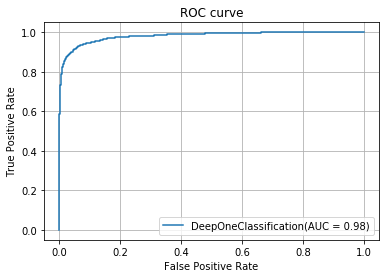

In [15]:
plt.plot(fpr, tpr, label='DeepOneClassification(AUC = %.2f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()

CPU times: user 164 ms, sys: 0 ns, total: 164 ms
Wall time: 163 ms


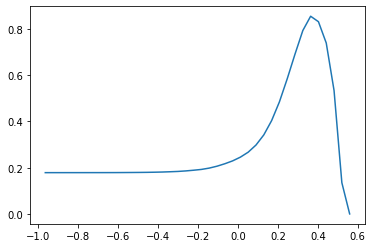

In [16]:
%%time
f1s = []
ax = np.linspace(min(Z),max(Z), 40)
for thresh in ax:
    f1s.append(f1_score(Z > thresh, test_l == 0))
plt.plot(ax,f1s)

In [17]:
print(max(f1s))

0.8552292632663576


In [18]:
ax[np.array(f1s).argmax()]

0.36384824857051834

In [19]:
svm_emb = OneClassSVM(kernel="rbf", gamma="auto")
svm_emb.fit(training_embeddings)

OneClassSVM(gamma='auto')

In [20]:
f1_score(svm_emb.predict(testing_embeddings)>0, test_l == 0)

0.6603900470746469

In [21]:
Z_train = clf._decision_function(training_embeddings)

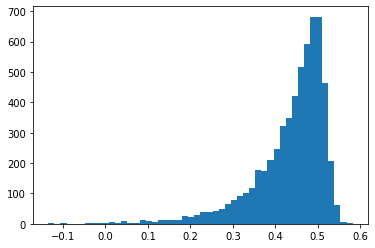

In [22]:
_ = plt.hist(Z_train, bins = 50)

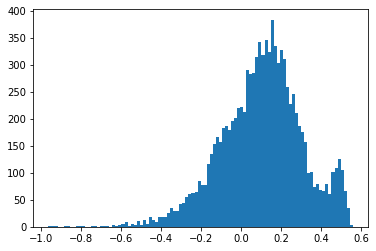

In [23]:
a,b,_ = plt.hist(Z, bins = 100)

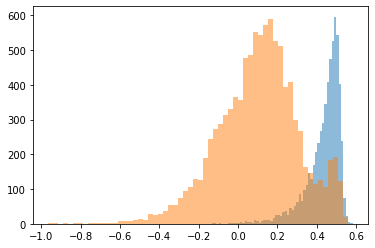

In [24]:
plt.hist(Z_train, bins = 60, alpha = 0.5)
plt.hist(Z, bins = 60, alpha = 0.5)
plt.show()